In [2]:
import argparse
import random
import numpy as np
from habitat_baselines.config.default import get_config
import habitat
import os
from habitat import Config, logger
from habitat import Config, Dataset
import matplotlib.pyplot as plt
import transformations as tf

In [3]:
import contextlib
import time
from collections import OrderedDict, defaultdict, deque
from typing import Any, Dict, List, Optional
from habitat_baselines.rl.ddppo.algo.ddp_utils import (
    EXIT,
    REQUEUE,
    add_signal_handlers,
    init_distrib_slurm,
    load_interrupted_state,
    requeue_job,
    save_interrupted_state,
)
from habitat_baselines.common.baseline_registry import baseline_registry
#from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.common.environments import get_env_class
from habitat_baselines.common.rollout_storage import RolloutStorage
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.common.utils import batch_obs, linear_decay
import numpy as np
import torch
import torch.distributed as distrib
import torch.nn as nn
from gym import spaces
from gym.spaces.dict_space import Dict as SpaceDict
from torch.optim.lr_scheduler import LambdaLR
from habitat_baselines.rl.ddppo.policy.resnet_policy import PointNavResNetPolicy
from habitat_baselines.rl.ddppo.algo.ddppo import DDPPO
from habitat_baselines.common.base_trainer import BaseRLTrainer
from habitat_baselines.common.baseline_registry import baseline_registry

In [4]:
import gym
import logging
from arguments import get_args
from config_init import get_config_init
from utils.storage import GlobalRolloutStorage, FIFOMemory
from utils.optimization import get_optimizer
from model import RL_Policy, Local_IL_Policy, Neural_SLAM_Module
from habitat.datasets.pointnav.pointnav_dataset import PointNavDatasetV1
import sys
import matplotlib
if sys.platform == 'darwin':
    matplotlib.use("tkagg")
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

In [5]:
from ppotrainer import PPOTrainer
from ddpotrainer import DDPPOTrainer
from constructenv import construct_envs
from my_env import MyRLEnvNew
from habitat import make_dataset
from constructenv import make_env_fn
from vectorenv import VectorEnv
from util import draw_top_down_map

In [6]:
argumnts = ''
args = get_args(argumnts)
args.num_processes = 4
num_scenes = args.num_processes
num_episodes = int(args.num_episodes)
config = get_config_init()
config.defrost()
config.NUM_PROCESSES = args.num_processes
config.freeze()
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")

costs = deque(maxlen=1000)
exp_costs = deque(maxlen=1000)
pose_costs = deque(maxlen=1000)

Auto GPU config:
Number of processes: 36
Number of processes on GPU 0: 0
Number of processes per GPU: 12


# One env

In [7]:
rank = range(args.num_processes)
dataset = PointNavDatasetV1(config.TASK_CONFIG.DATASET)
one_env = MyRLEnvNew(args=args, rank=rank, config=config, dataset=dataset)

KeyboardInterrupt: 

In [ ]:
obs = one_env.reset()

In [ ]:
plt.imshow(obs[0]['depth'])

# Test envs

In [7]:
envs = construct_envs(args, config, get_env_class(config.ENV_NAME))

2020-04-20 17:26:48,586 Initializing dataset PointNav-v1


In [8]:
observations, info = envs.reset()

In [9]:
from habitat_baselines.common.utils import batch_obs, linear_decay
from habitat_baselines.common.rollout_storage import RolloutStorage
from gym.spaces.box import Box
from resnet_policy import PointNavResNetPolicy
batch = batch_obs(observations)
obs_space = envs.observation_spaces[0]
rollouts = RolloutStorage(
            config.RL.PPO.num_steps,
            envs.num_envs,
            obs_space,
            envs.action_spaces[0],
            config.RL.PPO.hidden_size,
            num_recurrent_layers=config.RL.DDPPO.num_recurrent_layers)
rollouts.to(args.device)

In [10]:
for sensor in rollouts.observations:
    rollouts.observations[sensor][0].copy_(batch[sensor])

In [12]:
actor_critic = PointNavResNetPolicy(
            observation_space=envs.observation_spaces[0],
            action_space=envs.action_spaces[0],
            hidden_size=config.RL.PPO.hidden_size,
            rnn_type=config.RL.DDPPO.rnn_type,
            num_recurrent_layers=config.RL.DDPPO.num_recurrent_layers,
            backbone=config.RL.DDPPO.backbone,
            goal_sensor_uuid=config.TASK_CONFIG.TASK.GOAL_SENSOR_UUID,
            normalize_visual_inputs="rgb"
            in envs.observation_spaces[0].spaces,
        )
actor_critic.to(device);

In [13]:
obs_space = envs.observation_spaces[0]
ppo_cfg = config.RL.PPO
rollouts = RolloutStorage(
            ppo_cfg.num_steps,
            envs.num_envs,
            obs_space,
            envs.action_spaces[0],
            ppo_cfg.hidden_size,
            num_recurrent_layers=actor_critic.net.num_recurrent_layers)
rollouts.to(device)

In [14]:
step_observation = {k: v[rollouts.step] for k, v in rollouts.observations.items()}

In [15]:
(values, actions, actions_log_probs, recurrent_hidden_states) = actor_critic.act(
                step_observation,
                rollouts.recurrent_hidden_states[rollouts.step],
                rollouts.prev_actions[rollouts.step],
                rollouts.masks[rollouts.step])

In [16]:
outputs = envs.step([a[0].item() for a in actions])
observations, rewards, dones, infos = [list(x) for x in zip(*outputs)]
observations = [observations[ii] if i!=0 else observations[ii][0] for ii, i in enumerate(actions)]

In [17]:
from habitat_baselines.common.utils import batch_obs
batch = batch_obs(observations)
rewards = torch.tensor(
            rewards, dtype=torch.float, device='cuda:0')
rewards = rewards.unsqueeze(1)
masks = torch.tensor([[0.0] if done else [1.0] for done in dones],
            dtype=torch.float,
            device='cuda:0')

In [18]:
rollouts.insert(
            batch,
            recurrent_hidden_states,
            actions,
            actions_log_probs,
            values,
            rewards,
            masks)

In [19]:
OBSERVATION_SPACE_COMMAND = 'mapper_gt_pose'
for write_fn in envs._connection_write_fns:
    write_fn((OBSERVATION_SPACE_COMMAND, None))
obs = [read_fn() for read_fn in envs._connection_read_fns]

In [20]:
# slam
nslam_module = Neural_SLAM_Module(args).to(device)
slam_optimizer = get_optimizer(nslam_module.parameters(),
                               args.slam_optimizer)
# Storage
slam_memory = FIFOMemory(args.slam_batch_size)

In [21]:
map_size = args.map_size_cm // args.map_resolution
num_scenes = args.num_processes
full_w, full_h = map_size, map_size
local_w, local_h = int(full_w / args.global_downscaling), \
                   int(full_h / args.global_downscaling)
local_map = torch.zeros(num_scenes, 4, local_w, local_h).float().to(device)
local_pose = torch.zeros(num_scenes, 3).float().to(device)
poses = torch.from_numpy(np.asarray(
    [info[env_idx]['sensor_pose'] for env_idx
     in range(num_scenes)])
).float().to(device)

obs_new = torch.from_numpy(np.array([observations[i]['rgb'] for i in range(args.num_processes)])).float().to(device)

_, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
    nslam_module(obs_new, obs_new, poses, local_map[:, 0, :, :],
                 local_map[:, 1, :, :], local_pose)

/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


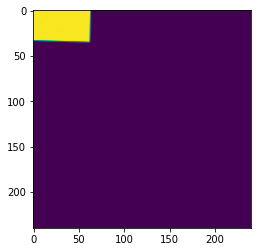

In [22]:
plt.imshow(local_map[0][0].cpu())

# Trainer

In [7]:
trainer_init = baseline_registry.get_trainer(config.TRAINER_NAME)

In [8]:
trainer = trainer_init(args, config)

2020-04-20 17:30:49,423 config: BASE_TASK_CONFIG_PATH: /habitat-api/configs/tasks/pointnav_gibson.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: 50
CMD_TRAILING_OPTS: []
ENV_NAME: MyRLEnvNew
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
LOG_FILE: train.log
LOG_INTERVAL: 10
NUM_PROCESSES: 4
NUM_UPDATES: 50000
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.txt
RL:
  DDPPO:
    backbone: resnet50
    distrib_backend: NCCL
    num_recurrent_layers: 2
    pretrained: Fals

In [9]:
trainer.train_init()

2020-04-20 17:30:51,769 Initializing dataset PointNav-v1


0


2020-04-20 17:31:59,549 agent number of trainable parameters: 12454917


In [10]:
trainer.train()

/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


RESET
TIME FOR FULL STEP:  55.832067012786865
TIME FOR FULL STEP:  11.472138166427612
TIME FOR FULL STEP:  2.0133156776428223
TIME FOR FULL STEP:  1.5479369163513184
TIME FOR FULL STEP:  9.391511917114258
TIME FOR FULL STEP:  2.033215045928955
TIME FOR FULL STEP:  1.9659950733184814
TIME FOR FULL STEP:  7.835747241973877
TIME FOR FULL STEP:  28.70339870452881
TIME FOR FULL STEP:  1.4724581241607666
TIME FOR FULL STEP:  10.45283842086792
TIME FOR FULL STEP:  5.195009231567383
TIME FOR FULL STEP:  1.897247076034546
TIME FOR FULL STEP:  7.096537113189697
TIME FOR FULL STEP:  8.197608947753906
TIME FOR FULL STEP:  2.2439284324645996
TIME FOR FULL STEP:  10.145846605300903
TIME FOR FULL STEP:  8.501797676086426
TIME FOR FULL STEP:  9.595996379852295
TIME FOR FULL STEP:  10.069940090179443
TIME FOR FULL STEP:  12.583564758300781
TIME FOR FULL STEP:  10.429518938064575
TIME FOR FULL STEP:  11.274292945861816
TIME FOR FULL STEP:  11.423981666564941
TIME FOR FULL STEP:  1.6081969738006592
TIME 

KeyboardInterrupt: 